## access hugging face for our data and a transformer model 

In [1]:
from huggingface_hub import notebook_login
notebook_login()

In [1]:
import torch
from datasets import Dataset, load_dataset, concatenate_datasets

## load dataset from hub

In [2]:
ds = load_dataset("gdurkin/s1_nlcd_ca",verification_mode='no_checks') # or "gdurkin/s1_nlcd_ca" "gdurkin/s1_nlcd_sfbay_plus"

Generating group_40_44 split:   0%|          | 0/1159 [00:00<?, ? examples/s]

Generating group_30_39 split:   0%|          | 0/2499 [00:00<?, ? examples/s]

Generating group_20_29 split:   0%|          | 0/2499 [00:00<?, ? examples/s]

Generating group_10_19 split:   0%|          | 0/2467 [00:00<?, ? examples/s]

Generating group_0_9 split:   0%|          | 0/2499 [00:00<?, ? examples/s]

In [3]:
ds_merged = concatenate_datasets([ds[k] for k in list(ds.keys())])
ds_split = ds_merged.train_test_split(test_size=0.1, seed=42)
dataset_train = ds_split['train'] #,download_mode = "force_redownload")['train']
dataset_test = ds_split['test'] #,download_mode = "force_redownload")['train']

In [4]:
len(dataset_train), len(dataset_test)

(10010, 1113)

### some in place transforms

In [5]:
if torch.backends.mps.is_built():
    device = torch.device('mps')
elif torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

In [6]:
device

device(type='mps')

### let's get the labels in order

### need to do some on-the-fly transforms on our incoming HF dataset

In [7]:
import torchvision
import torchvision.transforms.v2 as v2
from torchvision.transforms import InterpolationMode
import torchvision.transforms.functional as F
import numpy as np
import random
import cv2
from PIL import Image

# Original NLCD class labels and their descriptions
nlcd_class_color_dict = {
    11: 'Open Water',
    12: 'Perennial Ice/Snow',
    21: 'Developed, Open Space',
    22: 'Developed, Low Intensity',
    23: 'Developed, Medium Intensity',
    24: 'Developed, High Intensity',
    31: 'Barren Land (Rock/Sand/Clay)',
    41: 'Deciduous Forest',
    42: 'Evergreen Forest',
    43: 'Mixed Forest',
    52: 'Shrub/Scrub',
    71: 'Grassland/Herbaceous',
    81: 'Pasture/Hay',
    82: 'Cultivated Crops',
    90: 'Woody Wetlands',
    95: 'Emergent Herbaceous Wetlands'
}

# Sort the original class labels
original_labels = sorted(nlcd_class_color_dict.keys())

# Create mappings
label_mapping = {original_label: idx for idx, original_label in enumerate(original_labels)}
inverse_label_mapping = {idx: original_label for idx, original_label in enumerate(original_labels)}
num_classes = len(label_mapping)

# Create id2label and label2id dictionaries
id2label = {idx: nlcd_class_color_dict[original_label] for idx, original_label in enumerate(original_labels)}
label2id = {v: k for k, v in id2label.items()}


def remap_labels(label, label_mapping):
    # label: tensor of shape (H, W)
    label_np = label.numpy()
    label_np[label_np>95] = 12
    remapped_label_np = np.full_like(label_np, fill_value=255)  # Initialize with 255
    for original_label, new_label in label_mapping.items():
        remapped_label_np[label_np == original_label] = new_label
    return torch.from_numpy(remapped_label_np)


def adjust_gamma(image, gamma=1.0):
    # image: np.array (H,W,C) in uint8
    invGamma = 1.0 / gamma
    table = np.array([((i / 255.0) ** invGamma) * 255
                      for i in np.arange(0, 256)]).astype("uint8")
    return cv2.LUT(np.array(image, 'uint8'), table)

def prep_dataset_train(examples, target_size=240, p_hflip=0.3, p_vflip=0.3, gamma_base  = 0.65):
    """
    Preprocessing function for training dataset.
    
    Args:
        examples (dict): A batch of examples from the dataset.
        target_size (int): Desired size for resizing.
        p_hflip (float): Probability of horizontal flip.
        p_vflip (float): Probability of vertical flip.

    Returns:
        dict: Transformed batch with 'pixel_values' and 'labels'.
    """

    # Define transforms that do not include random flips or intensity
    # We will do flips and intensity modifications manually.
    image_transform = v2.Compose([
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.BILINEAR),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    label_transform = v2.Compose([
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.NEAREST),
        v2.PILToTensor(),
        v2.Lambda(lambda x: x.squeeze(0)),  # Remove channel dimension if present
        v2.Lambda(lambda x: remap_labels(x, label_mapping)),
        v2.Lambda(lambda x: x.long()),  # Ensure labels are integers
    ])

    images = examples['pixel_values']
    labels = examples['labels']

    out_images = []
    out_labels = []

    for img, lbl in zip(images, labels):
        # Convert to PIL if tensor or array
        if torch.is_tensor(img) or isinstance(img, np.ndarray):
            img = v2.ToPILImage()(img)
        if torch.is_tensor(lbl) or isinstance(lbl, np.ndarray):
            lbl = v2.ToPILImage()(lbl)

        # Apply random horizontal flip to both image and label
        if random.random() < p_hflip:
            img = F.hflip(img)
            lbl = F.hflip(lbl)

        # Apply random vertical flip to both image and label
        if random.random() < p_vflip:
            img = F.vflip(img)
            lbl = F.vflip(lbl)

        # Random brightness factor: ±10%
        brightness_factor = random.uniform(0.9, 1.1)
        # Random gamma factor: ±10%
        gamma_factor = random.uniform(0.9, 1.1)

        # Convert image to numpy for brightness/gamma adjustments
        img_array = np.array(img, dtype='uint8')

        # Apply gamma correction
        if gamma_factor != 1.0:
            img_array = adjust_gamma(img_array, gamma=gamma_factor*gamma_base)

        # Apply brightness adjustment
        if brightness_factor != 1.0:
            # multiply all pixel values by brightness_factor and clip
            img_array = np.clip(img_array * brightness_factor, 0, 255).astype('uint8')

        # Convert back to PIL Image after adjustments
        img = Image.fromarray(img_array)

        # Now apply the resizing and tensor conversions
        img = image_transform(img)
        lbl = label_transform(lbl)

        out_images.append(img)
        out_labels.append(lbl)

    encoding = {}
    encoding["pixel_values"] = out_images  # List of tensors
    encoding["labels"] = out_labels        # List of tensors

    return encoding

def prep_dataset_validate(examples, target_size=240):
    """
    Preprocessing function for validation dataset.
    
    Args:
        examples (dict): A batch of examples from the dataset.
        target_size (int): Desired size for resizing.
    
    Returns:
        dict: Transformed batch with 'pixel_values' and 'labels'.
    """
    # Transforms for input images
    image_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.BILINEAR),
        v2.PILToTensor(),
        v2.ToDtype(torch.float32, scale=True),
    ])

    # Transforms for target images
    label_transform = v2.Compose([
        v2.ToPILImage(),
        v2.Resize((target_size, target_size), interpolation=InterpolationMode.NEAREST),
        v2.PILToTensor(),
        v2.Lambda(lambda x: x.squeeze(0)),
        v2.Lambda(lambda x: remap_labels(x, label_mapping)),
        v2.Lambda(lambda x: x.long()),
    ])

    # Apply transforms
    images = [image_transform(x) for x in examples['pixel_values']]
    labels = [label_transform(y) for y in examples['labels']]

    encoding = {}
    encoding["pixel_values"] = images  # List of tensors
    encoding['labels'] = labels        # List of tensors
    return encoding


# Set the transforms with the desired target size (default is 240)
dataset_train.set_transform(lambda examples: prep_dataset_train(examples, target_size=240))
dataset_test.set_transform(lambda examples: prep_dataset_validate(examples, target_size=240))


In [8]:
id2label

{0: 'Open Water',
 1: 'Perennial Ice/Snow',
 2: 'Developed, Open Space',
 3: 'Developed, Low Intensity',
 4: 'Developed, Medium Intensity',
 5: 'Developed, High Intensity',
 6: 'Barren Land (Rock/Sand/Clay)',
 7: 'Deciduous Forest',
 8: 'Evergreen Forest',
 9: 'Mixed Forest',
 10: 'Shrub/Scrub',
 11: 'Grassland/Herbaceous',
 12: 'Pasture/Hay',
 13: 'Cultivated Crops',
 14: 'Woody Wetlands',
 15: 'Emergent Herbaceous Wetlands'}

### load model

try a state of the art model - mask2former

In [9]:
from transformers import AutoImageProcessor, Mask2FormerForUniversalSegmentation

# load Mask2Former fine-tuned on Mapillary Vistas semantic segmentation
num_labels = len(id2label)

fb_model = "facebook/mask2former-swin-large-mapillary-vistas-semantic" #from Facebook Research
#my_model = "gdurkin/s1_nlcd_mask2former_v3" 
my_model = "gdurkin/s1_nlcd_mask2former_v5" # "gdurkin/cdl_mask2former_v3_mspc"


loaded_model = Mask2FormerForUniversalSegmentation.from_pretrained(my_model,
    label2id=label2id,
    id2label = id2label,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

loaded_model = loaded_model.to(device)

# not a problem to get the following message, it goes away once you start training. It only occurs beacuse the pre-trained model was trained on a different number of classes: [You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference]

/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree.

config.json:   0%|          | 0.00/75.8k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

In [66]:
# PATH = '/home/xxx/Downloads/mask2former_s1_nlcd/s1_nlcd-mask2former_v3'

# loaded_model.load_state_dict(torch.load(PATH))

In [10]:
from transformers import Mask2FormerImageProcessor
from torch.utils.data import DataLoader
# Create a preprocessor
preprocessor = Mask2FormerImageProcessor(ignore_index=255, reduce_labels=False, do_resize=False, do_rescale=False, do_normalize=False)

def collate_fn_mask(batch):
    try:
        images = [el['pixel_values'] for el in batch]
        segmentation_maps = [el['labels'] for el in batch]

        batch = preprocessor(
            images,
            segmentation_maps=segmentation_maps,
            return_tensors="pt",
        )
        batch["original_images"] = images
        batch["original_segmentation_maps"] = segmentation_maps
        return batch
    except Exception as e:
        # Log the error
        print(f"Error in collate_fn_mask: {e}")
        return None

test_dataloader = DataLoader(dataset_test, batch_size=1, shuffle=True, collate_fn=collate_fn_mask)
train_dataloader = DataLoader(dataset_train, batch_size=2, shuffle=True, collate_fn=collate_fn_mask)

#larger batch sizes may cause your vram to saturate OOM

In [15]:
batch = next(iter(train_dataloader))

In [16]:
for k,v in batch.items():
  if isinstance(v, torch.Tensor):
    print(k,v.shape)
  else:
    print(k,v[0].shape)

pixel_values torch.Size([2, 3, 240, 240])
pixel_mask torch.Size([2, 240, 240])
mask_labels torch.Size([7, 240, 240])
class_labels torch.Size([7])
original_images torch.Size([3, 240, 240])
original_segmentation_maps torch.Size([240, 240])


In [17]:
pixel_values = batch["pixel_values"][0].numpy()
pixel_values.shape

(3, 240, 240)

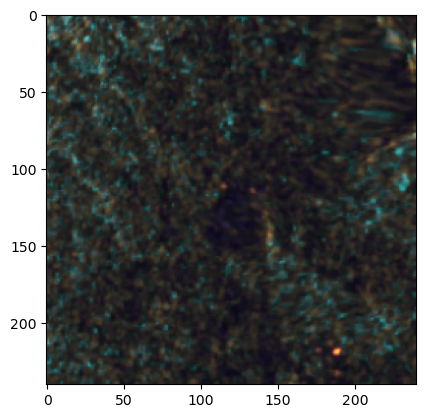

In [18]:
import matplotlib.pyplot as plt
plt.imshow(pixel_values.transpose(1,2,0))

In [19]:
import evaluate
metric = evaluate.load("mean_iou")

# Initialize IoU calculator
class IOUCalculator:
    def __init__(self, num_classes):
        self.num_classes = num_classes
        self.reset()

    def reset(self):
        self.tp = torch.zeros(self.num_classes, dtype=torch.float32)
        self.fp = torch.zeros(self.num_classes, dtype=torch.float32)
        self.fn = torch.zeros(self.num_classes, dtype=torch.float32)

    def update(self, predictions, targets):
        for cls in range(self.num_classes):
            pred_mask = (predictions == cls)
            target_mask = (targets == cls)
            self.tp[cls] += (pred_mask & target_mask).sum().item()
            self.fp[cls] += (pred_mask & ~target_mask).sum().item()
            self.fn[cls] += (~pred_mask & target_mask).sum().item()

    def compute(self):
        ious = []
        for cls in range(self.num_classes):
            union = self.tp[cls] + self.fp[cls] + self.fn[cls]
            if union > 0:
                ious.append(self.tp[cls] / union)
            else:
                ious.append(float('nan'))  # Use NaN for classes not present
        return ious

iou_calculator = IOUCalculator(num_classes=num_classes)

In [73]:
import pandas as pd
df_metrics =  pd.DataFrame(columns=[])

### training loop:

In [74]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

In [75]:
# Initialize variables to store losses and steps
train_losses = []
train_steps = []
test_losses = []
test_steps = []
iou_scores = pd.DataFrame(columns=["Class", "IoU", "Epoch", "Batch"])
lrs = []

In [76]:
epoch_count = 10
if len(df_metrics)>0:
    last_epoch = round(df_metrics['step'].max())
else:
    last_epoch = 0

total_epochs = epoch_count + last_epoch

In [79]:
total_epochs, epoch_count, last_epoch

(10, 10, 0)

In [80]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import pandas as pd
import numpy as np
from ipywidgets import Output
from IPython.display import display, clear_output
import seaborn as sns
from matplotlib.ticker import MultipleLocator
import gc

# Set Seaborn style for better aesthetics
sns.set(style="whitegrid")

# Update matplotlib parameters for better fonts
plt.rcParams.update({'font.size': 12})
plt.rcParams['font.family'] = 'sans-serif'

# Instead of vanilla Adam, use AdamW:
optimizer = torch.optim.AdamW(loaded_model.parameters(), lr=1e-6, weight_decay=1e-4)

# Instead of ReduceLROnPlateau, try a cosine annealing with warm restarts scheduler:
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=10, T_mult=2)

# Initialize tracking variables
train_losses = []
val_losses = []
lrs = []
test_steps = []
test_losses = []
df_metrics = pd.DataFrame()
best_val_loss = float('inf')
patience = 4
epochs_no_improve = 0

# Initialize lists to store x-axis values
epoch_progress_steps = []
validation_progress_steps = []
batch_losses = []
epoch_lrs = []

# Configurations
validate_steps = max(1, len(train_dataloader) // 5)  # Validate 5 times per epoch or at least once per epoch

# Prepare the output widgets
plot_output = Output()
log_output = Output()

# Display the outputs
display(log_output, plot_output)

for epoch in range(last_epoch + 1, epoch_count + last_epoch + 1):
    with log_output:
        print(f"\nEpoch: {epoch}/{epoch_count + last_epoch}")
    loaded_model.train()
    running_loss = 0.0
    num_samples = 0
    total_batches = len(train_dataloader)
    epoch_steps = []

    for idx, batch in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()

        if batch is None:
            with log_output:
                print(f"Batch {idx + 1} is None. Skipping.")
            continue

        # Forward pass
        try:
            outputs = loaded_model(
                pixel_values=batch["pixel_values"].to(device),
                mask_labels=[mask_label.to(device) for mask_label in batch["mask_labels"]],
                class_labels=[cls_label.to(device) for cls_label in batch["class_labels"]],
            )
        except Exception as e:
            with log_output:
                print(f"Error during forward pass at Batch {idx + 1}: {e}")
            continue

        # Compute loss
        loss = outputs.loss

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Compute progress percentage within the epoch
        progress = (idx + 1) / total_batches * 100
        x_value = epoch + progress / 100
        epoch_progress_steps.append(x_value)
        epoch_steps.append(progress)

        # Learning rate tracking
        current_lr = optimizer.param_groups[0]['lr']
        lrs.append(current_lr)
        epoch_lrs.append(current_lr)

        # Accumulate loss
        batch_size = batch["pixel_values"].size(0)
        running_loss += loss.item() * batch_size
        num_samples += batch_size
        average_loss = running_loss / num_samples
        batch_losses.append(average_loss)

        # Update plots every 50 batches
        if (idx + 1) % 50 == 0 or (idx + 1) == total_batches:
            with log_output:
                print(f"Epoch {epoch}, Batch {idx + 1}/{total_batches}, Loss: {average_loss:.4f}, LR: {current_lr:.6f}")

            with plot_output:
                clear_output(wait=True)
                fig, ax1 = plt.subplots(figsize=(12, 8))

                # Plot Training Loss
                ax1.plot(epoch_progress_steps, batch_losses, label="Training Loss", color='#aec6cf', linewidth=2)

                # Plot Validation Loss
                if validation_progress_steps and test_losses:
                    ax1.plot(validation_progress_steps, test_losses, label="Validation Loss", color='#ffb347', linewidth=2)

                ax1.set_xlabel("Epoch Number and Progress")
                ax1.set_ylabel("Loss")
                ax1.set_title("Training and Validation Loss", fontsize=16, fontweight='bold')

                # Remove gridlines on ax1 (left y-axis)
                ax1.grid(False)

                # Determine y-limits based on last 300 training losses + all validation losses
                train_data_for_scale = batch_losses[-300:] if len(batch_losses) > 300 else batch_losses
                combined_data = np.array(train_data_for_scale)
                if test_losses:
                    combined_data = np.concatenate([combined_data, test_losses])
                ymin = np.min(combined_data)
                ymax = np.max(combined_data)
                ax1.set_ylim(ymin, ymax)

                ax1.yaxis.set_major_locator(MultipleLocator(1))

                # Create a twin y-axis for Learning Rate
                ax2 = ax1.twinx()

                # Plot Learning Rate
                ax2.plot(epoch_progress_steps, lrs, label="Learning Rate", color='#77dd77', linewidth=2)
                ax2.set_ylabel("Learning Rate")

                # Disable gridlines on ax2 (right y-axis)
                ax2.grid(False)

                # Add alternating background bands aligned with y-axis ticks
                yticks = ax1.get_yticks()
                for i in range(len(yticks) - 1):
                    y0 = yticks[i]
                    y1 = yticks[i + 1]
                    if i % 2 == 0:
                        ax1.axhspan(y0, y1, facecolor='lightblue', alpha=0.2)

                # Legends
                lines_1, labels_1 = ax1.get_legend_handles_labels()
                lines_2, labels_2 = ax2.get_legend_handles_labels()
                ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

                plt.tight_layout()
                plt.show()

        # Validation step within epoch
        if (idx + 1) % validate_steps == 0 or (idx + 1) == total_batches:
            loaded_model.eval()
            val_running_loss = 0.0
            val_num_samples = 0
            iou_calculator.reset()

            with torch.no_grad():
                for val_batch in test_dataloader:
                    if val_batch is None:
                        with log_output:
                            print("Validation batch is None. Skipping.")
                        continue

                    try:
                        val_outputs = loaded_model(
                            pixel_values=val_batch["pixel_values"].to(device),
                            mask_labels=[mask_label.to(device) for mask_label in val_batch["mask_labels"]],
                            class_labels=[cls_label.to(device) for cls_label in val_batch["class_labels"]],
                        )
                    except Exception as e:
                        with log_output:
                            print(f"Error during validation forward pass: {e}")
                        continue

                    # Compute loss
                    val_loss = val_outputs.loss

                    # Accumulate validation loss
                    val_batch_size = val_batch["pixel_values"].size(0)
                    val_running_loss += val_loss.item() * val_batch_size
                    val_num_samples += val_batch_size

                    # IoU Calculations
                    original_images = val_batch["original_images"]
                    target_sizes = [(img.shape[1], img.shape[2]) for img in original_images]

                    try:
                        predicted_segmentation_maps = preprocessor.post_process_semantic_segmentation(
                            outputs=val_outputs,
                            target_sizes=target_sizes
                        )
                    except Exception as e:
                        with log_output:
                            print(f"Post-processing error: {e}")
                        continue

                    ground_truth_segmentation_maps = val_batch["original_segmentation_maps"]

                    for pred_map, gt_map in zip(predicted_segmentation_maps, ground_truth_segmentation_maps):
                        iou_calculator.update(pred_map.cpu(), gt_map.cpu())

            # Compute metrics after validation
            per_class_iou = iou_calculator.compute()

            metrics_update = {f"iou_{id2label[i]}": v for i, v in enumerate(per_class_iou)}
            metrics_update['step'] = x_value
            metrics_update['loss'] = val_running_loss / val_num_samples
            df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics_update])], ignore_index=True)

            # Compute average validation loss
            val_average_loss = val_running_loss / val_num_samples
            val_losses.append(val_average_loss)
            test_losses.append(val_average_loss)
            validation_progress_steps.append(x_value)

            with log_output:
                print(f"Intermediate Validation Loss at Batch {idx + 1}: {val_average_loss:.4f}")
                print(f"IoU Metrics: {metrics_update}")

            with plot_output:
                clear_output(wait=True)
                fig, ax1 = plt.subplots(figsize=(12, 8))

                # Plot Training Loss
                ax1.plot(epoch_progress_steps, batch_losses, label="Training Loss", color='#aec6cf', linewidth=2)

                # Plot Validation Loss
                ax1.plot(validation_progress_steps, test_losses, label="Validation Loss", color='#ffb347', linewidth=2)

                ax1.set_xlabel("Epoch Number and Progress")
                ax1.set_ylabel("Loss")
                ax1.set_title("Training and Validation Loss", fontsize=16, fontweight='bold')

                ax1.grid(False)

                # Determine y-limits based on last 300 training losses + all validation losses
                train_data_for_scale = batch_losses[-300:] if len(batch_losses) > 300 else batch_losses
                combined_data = np.array(train_data_for_scale)
                if test_losses:
                    combined_data = np.concatenate([combined_data, test_losses])
                ymin = np.min(combined_data)
                ymax = np.max(combined_data)
                ax1.set_ylim(ymin, ymax)

                ax1.yaxis.set_major_locator(MultipleLocator(1))

                ax2 = ax1.twinx()
                ax2.plot(epoch_progress_steps, lrs, label="Learning Rate", color='#77dd77', linewidth=2)
                ax2.set_ylabel("Learning Rate")
                ax2.grid(False)

                yticks = ax1.get_yticks()
                for i in range(len(yticks) - 1):
                    y0 = yticks[i]
                    y1 = yticks[i + 1]
                    if i % 2 == 0:
                        ax1.axhspan(y0, y1, facecolor='lightblue', alpha=0.2)

                lines_1, labels_1 = ax1.get_legend_handles_labels()
                lines_2, labels_2 = ax2.get_legend_handles_labels()
                ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right', fontsize=10)

                plt.tight_layout()
                plt.show()

            loaded_model.train()

    # Epoch-level logging
    average_train_loss = running_loss / num_samples
    train_losses.append(average_train_loss)
    with log_output:
        print(f"\nEpoch {epoch} Training Loss: {average_train_loss:.4f}")

    # Use the CosineAnnealingWarmRestarts scheduler step
    scheduler.step()

    # Check for improvement
    if val_losses:
        val_average_loss = val_losses[-1]
    else:
        val_average_loss = average_train_loss

    if val_average_loss < best_val_loss:
        best_val_loss = val_average_loss
        epochs_no_improve = 0
        torch.save(loaded_model.state_dict(), 'best_model.pth')
        with log_output:
            print("Best model saved.")
    else:
        epochs_no_improve += 1
        with log_output:
            print(f"No improvement for {epochs_no_improve} epochs.")
        if epochs_no_improve >= patience:
            with log_output:
                print("Early stopping triggered.")
            break

    loaded_model.train()
    gc.collect()
    torch.cuda.empty_cache()


Output()

Output()

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

  0%|          | 0/5005 [00:00<?, ?it/s]

In [82]:
df_metrics.columns

Index(['iou_Open Water', 'iou_Perennial Ice/Snow', 'iou_Developed, Open Space',
       'iou_Developed, Low Intensity', 'iou_Developed, Medium Intensity',
       'iou_Developed, High Intensity', 'iou_Barren Land (Rock/Sand/Clay)',
       'iou_Deciduous Forest', 'iou_Evergreen Forest', 'iou_Mixed Forest',
       'iou_Shrub/Scrub', 'iou_Grassland/Herbaceous', 'iou_Pasture/Hay',
       'iou_Cultivated Crops', 'iou_Woody Wetlands',
       'iou_Emergent Herbaceous Wetlands', 'step', 'loss'],
      dtype='object')

In [83]:
df_metrics.index

RangeIndex(start=0, stop=50, step=1)

/tmp/ipykernel_115046/1081193516.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_metrics[['iou_Open Water','iou_Emergent Herbaceous Wetlands','iou_Cultivated Crops','iou_Evergreen Forest',


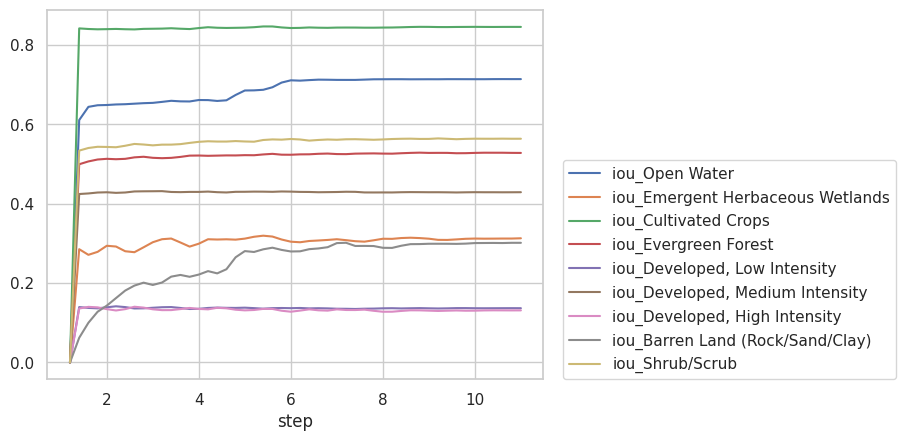

In [84]:
df_metrics[['iou_Open Water','iou_Emergent Herbaceous Wetlands','iou_Cultivated Crops','iou_Evergreen Forest',
       'iou_Developed, Low Intensity', 'iou_Developed, Medium Intensity',
       'iou_Developed, High Intensity', 'iou_Barren Land (Rock/Sand/Clay)',
       'iou_Shrub/Scrub','step']].set_index('step').rolling(window=2).mean().fillna(method='ffill').fillna(0).plot()
plt.legend(loc=(1.04, 0))

<Axes: >

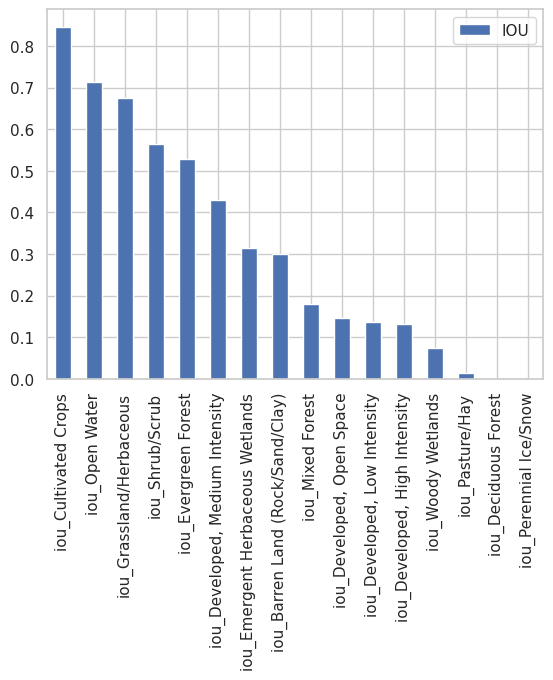

In [85]:
df_perf = df_metrics.drop(['loss','step'],axis=1).tail(1).T#.toframe()#.columns#.sort_values().T
df_perf.columns = ['IOU']
df_perf  = df_perf.sort_values('IOU', ascending = False)
df_perf['IOU'] = df_perf['IOU'].apply(lambda x: np.array(x))
df_perf.plot(kind='bar')

Text(0, 0.5, 'Mask2Former Loss')

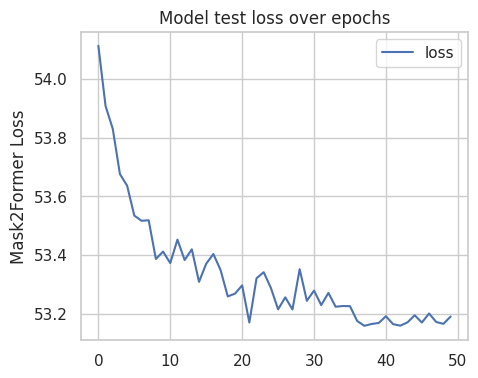

In [86]:
fig, ax = plt.subplots(figsize = (5,4))
df_metrics[['loss']].plot(ax = ax)
plt.title('Model test loss over epochs')
plt.ylabel('Mask2Former Loss')

### we can save the model locally and also push it to hugging face:

In [20]:
import os
code_path = os.getcwd()
model_dir = "mask2former_s1_nlcd"
os.makedirs(model_dir, exist_ok=True)
print(code_path)

model_name = 's1_nlcd-mask2former_v5'


PATH = code_path + '/' +model_dir + '/' + model_name
print('PATH =',PATH)

torch.save(loaded_model.state_dict(), PATH)

/Users/gabriela.durkin
PATH = /Users/gabriela.durkin/mask2former_s1_nlcd/s1_nlcd-mask2former_v5


In [22]:
#loaded_model.push_to_hub("xxx")

let's demonstrate that our model is a fine-tined version of the facebook model

In [23]:
fb_model = "facebook/mask2former-swin-large-mapillary-vistas-semantic"

In [24]:
test_model = Mask2FormerForUniversalSegmentation.from_pretrained(fb_model,
    label2id=label2id,
    id2label = id2label,
    num_labels=num_labels,
    ignore_mismatched_sizes=True,
)

/Users/gabriela.durkin/miniforge3/envs/aienv/lib/python3.11/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/79.5k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/866M [00:00<?, ?B/s]

Some weights of Mask2FormerForUniversalSegmentation were not initialized from the model checkpoint at facebook/mask2former-swin-large-mapillary-vistas-semantic and are newly initialized because the shapes did not match:
- class_predictor.bias: found shape torch.Size([66]) in the checkpoint and torch.Size([17]) in the model instantiated
- class_predictor.weight: found shape torch.Size([66, 256]) in the checkpoint and torch.Size([17, 256]) in the model instantiated
- criterion.empty_weight: found shape torch.Size([66]) in the checkpoint and torch.Size([17]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [25]:
PATH = '/Users/xxx/mask2former_s1_nlcd/s1_nlcd-mask2former_v5'

test_model.load_state_dict(torch.load(PATH,weights_only=True))

<All keys matched successfully>

### let's put the model in Fused explorer file system

In [30]:
#!pip install --upgrade fused
import fused
fused._env('prod')
fused.options.show.show_widget = False
fused.options.request_timeout = 180

In [39]:
fused.api.upload(PATH, fused_model_path)

In [36]:
print(f"Model saved locally as {PATH} and uploaded to {fused_model_path}")

Model saved locally as /Users/gabriela.durkin/mask2former_s1_nlcd/s1_nlcd-mask2former_v5 and uploaded to fd://gabe/models/s1_nlcd_transformer
